# Covid-19 Prediction and the Effects of Mobility

## Our model
We use a compartmental model to describe the evolution of the disease. Our compartments are:
- **Susceptible**: healthy individuals that may catch the disease
- **Exposed**: individuals that have contracted the disease but are not infectious
- **Infected**: individuals that have the disease and may infect others
- **Recovered**: those who have passed through the disease, and will not be infected again
- **Dead**: individuals who have succumbed to the disease

In the future, we want to explore including an **Asymptomatic** compartment, which would be comprised of individuals who are infectious but show few/no symptoms.

We assume the discrete-time dynamics evolve as follows:

$$S(t+1) = S(t) - \rho S(t)\cdot[\beta_E E(t) + \beta_I I(t)]$$

$$E(t+1) = (1 - \rho_{EI})E(t) + \rho S(t)\cdot[\beta_E E(t) + \beta_I I(t)]$$

$$I(t+1) = (1 - \rho_{IH} - \rho_{IR} - \rho_{ID})I(t) + \rho_{EI}E(t)$$

$$H(t+1) = (1 - \rho_{HR} - \rho_{HD})H(t) + \rho_{IH}I(t)$$

$$R(t+1) = R(t) + \rho_{IR}I(t) + \rho_{HR}H(t)$$

$$D(t+1) = D(t) + \rho_{ID}I(t) + \rho_{HD}H(t)$$

## Effects of mobility (local)

Rather than simple infection rates, we are assuming that the terms $\beta_E, \beta_I$ are in fact functions of mobility terms in the following way. 

We take time series of mobility change data for each county in the US, $x_i \in [-1,1]^6$, measured from a baseline established in January and February.

Then, we learn a set of parameters $w_i \in \mathbb{R}^6, b_i \in \mathbb{R}$ for each county such that

$$\beta_E = \sigma(w_i^\intercal x_i + b_i) = \frac{1}{1 + e^{-w_i^\intercal x_i - b_i}}.$$


We do the same for $\beta_I$, with independent weights.

Our goal will be to learn all parameters $w, b$ above, for each county.


## Effects of age (global)

We treat the transition probabilities between exposed, infected, hospitalized, recovered, and dead compartments in a similar way.

We create ratios of ages within 3 different categories in each county, $a_i \in [0,1]^3, \sum_{j=1}^3{a_{ij}} = 1$. We currently split the groups as 0-24 years, 24-64 years, and 65+ years, although this may easily be changed.

Then, we learn a set of parameters $w \in \mathbb{R}^3, b \in \mathbb{R}$ which do not vary by county such that

$$\rho_{EI} = \sigma(w_i^\intercal a_i + b_i) = \frac{1}{1 + e^{-w_i^\intercal a_i - b_i}}.$$

The same is true for $\rho_{IH},~\rho_{IR},~\rho_{HR},~\rho_{ID},~\rho_{HD}$.

Our goal will be to learn all parameters $w, b$ above, globally across all counties.





## 1. Learning mobility parameters

We learn the mobility parameters $w_i, b_i$ for each county by minimizing the prediction error using autograd:

$$\text{err}(\{w_i,b_i\}) = \sum_{i=1}^N\left\lVert X_{true} - X_{predicted}(w_i,b_i)\right\rVert_2^2 $$

$$ = \sum_{i=1}^N\sum_{t=1}^T\left( H_{true}(t) - H_{predicted}(w_i,b_i)(t)\right)^2 + \left( R_{true}(t) - R_{predicted}(w_i,b_i)(t)\right)^2 + \left( D_{true}(t) - D_{predicted}(w_i,b_i)(t)\right)^2 $$

To keep things realistic, we only compare predictions of the recovered compartment which we can measure.

In practice, we can do this learning incredibly well. To make things more difficult, we also try to learn the parameters $c_0 := E[0], \rho_{EI}, \rho_{IR}$ as well.

1.154373233652006e-09


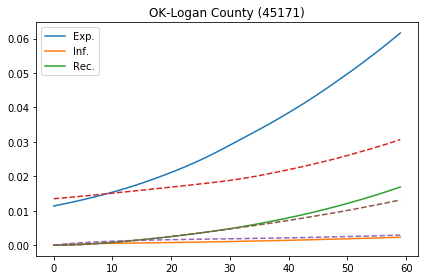

In [7]:
from Compartmental_Model import setup, optimize, prediction_loss, plot_prediction

# Set up and train with 30 days of data for 1 county. Do cross-validation of 60 days
setup(num_counties=1, train_days=30)
optimized_params = optimize(num_iters=1000, step_size=0.01, num_batches=5, predict_length=60)

# Plot predictions for 60 days
print(prediction_loss(optimized_params))
plot_prediction(optimized_params, 60)

## 2. Multitask learning

How should we incorporate the global parameters $\rho_{EI}, \rho_{IR}$? Should we enforce that they're the same? Regularize them? If so, what does this mean in terms of a prior?